In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
import re
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/barbara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
def get_unique_words(text):
    words = [word for message in text for word in message]
    return set(words)

def co_occurence_matrix_with_window(text, window_size, stop_words):
    '''
    Calculates the co-occurence matrix using a sliding window of size window_size as context    
    Output is (unique) words x (unique) words
    '''
    unique_words = get_unique_words(text)
    n = len(unique_words) #number of unique words
    co_matrix = pd.DataFrame(data=np.zeros([n,n]), columns=unique_words, index=unique_words, dtype='int')

    #for each word in each message, counts +1 for each pair [word,context]
    for message in text:
        msg_len = len(message)
        for i, word in enumerate(message):
            first = max(i - window_size, 0)
            last = min(i + window_size + 1, msg_len)
            for context in message[first:last]:
                co_matrix.loc[word,context] += 1
    return co_matrix  
    
def word_occurence_matrix(text, target=None, stop_words=None, binary=True, preprocess_text=False):  
    '''
    Output is messages x (unique) words
    
    If binary=True, then each element represents if the word is in the message or not.
    Otherwise, it represents the count of how many times that word appears in that message.
    ''' 
    if target:
        text = list(filter(lambda x : target in x.split(), text)) #Filter comments in which target word is present
        
    preprocessor = CountVectorizer(strip_accents='unicode').build_preprocessor()   
    if stop_words:        
        stop_words = [preprocessor(word) for word in stop_words] #preprocesses stop words
    if preprocess_text:
        text = [preprocessor(msg) for msg in text] #preprocesses text
        
    #calculates word count for each message
    vectorizer = CountVectorizer(strip_accents='unicode', stop_words=stop_words, binary=binary, dtype=np.uint16)
    X = vectorizer.fit_transform(text).toarray()
    
    labels = vectorizer.get_feature_names()
    
    return X, labels

def co_occurence_matrix(word_occurence_matrix):
    '''
    Co-occurence matrix created based on the word count/occurence matrix.     
    In other words, this co-occurence matrix will consider each message as the context for all words in it.
    '''
    co_X = word_occurence_matrix.T @ word_occurence_matrix
    np.fill_diagonal(co_X, 0)
    return co_X

def score_ngrams(text, freq_filter=1, score_metric=BigramAssocMeasures().pmi):
    '''
    Score n-grams using score_metric. Defaults to PMI.
    '''
    words = [word for msg in text for word in msg.split()]
    finder = BigramCollocationFinder.from_words(words)
    finder.apply_freq_filter(freq_filter)
    return finder.score_ngrams(score_metric)

In [5]:
comments = pd.read_csv('../../dados/instagram/filtered_comments.csv')

comments_by_channel = []
channels = []
for channel, group in comments.groupby('dono_do_post'):
    channel_comments = group['texto_do_comentario']
    comments_by_channel.append(channel_comments)
    channels.append(channel)

### 0. Olhando comentários duplicados

In [6]:
duplicates_stats = []
for channel in channels:
    duplicated = comments[(comments['dono_do_post'] == channel) & 
                          comments.duplicated(subset=['texto_do_comentario','usuario','dono_do_post'], 
                                              keep=False) &                           
                          (comments['texto_do_comentario']!='')]
    count = len(duplicated)
    count_unique = len(duplicated.drop_duplicates(subset=['texto_do_comentario','usuario','dono_do_post']))
    n_comments = len(comments[comments['dono_do_post'] == channel])
    ratio = count / n_comments
    users = len(duplicated['usuario'].unique())
    mean = duplicated.groupby('usuario')['id_comment'].count().mean()
    duplicates_stats.append([n_comments,count,count_unique,ratio,users,mean])
    
pd.DataFrame(duplicates_stats, index=channels, columns=['comentários', 'duplicatas','duplicatas unicas',
                                                        '% duplicatas', 'usuarios', 'media p/ usuario'])

,comentários,duplicatas,duplicatas unicas,% duplicatas,usuarios,media p/ usuario
dr.galvao,243,6,3,0.024691,3,2.000000
dralaindutra,3679,121,55,0.032889,49,2.469388
drfelipeades,614,16,7,0.026059,7,2.285714
drfernandoneuro,31141,2789,893,0.089560,481,5.798337
drlairribeiro,1950,16,8,0.008205,8,2.000000
imedlkep,468,4,2,0.008547,2,2.000000
juliommais,77,0,0,0.000000,0,NaN
sitedrauziovarella,27001,864,372,0.031999,343,2.518950


### Pré-processamento

In [7]:
comments = pd.read_csv('../../dados/instagram/filtered_comments.csv')
stop_words = [word.rstrip() for word in open('../stopwords.txt')]

preprocessor = CountVectorizer(strip_accents='unicode').build_preprocessor() 
#lowercase and strip accents
stop_words = [preprocessor(word) for word in stop_words]
#English and Spanish Words
stop_words.extend(['you', 'good', 'the', 'to', 'live', 'very', 'your', 'work', 'is', 'my', 'from', 'love', 'and', 
                   'in', 'thank', 'informative', 'are', 'of', 'un', 'english', 'what', 'mi', 'hello', 'el', 
                   'but', 'doctor'])
#Nomes Próprios
stop_words.extend(['drauzio', 'varella', 'lucy', 'kerr', 'julio', 'pereira','fernando', 'pinto', 'gomes', 'lair', 
                   'ribeiro', 'alvaro', 'galvao', 'felipe', 'ades', 'gomez', 'alain', 'dutra'])
#Pronomes e preposições
stop_words.extend(['pra', 'vc', 'todos', 'tudo', 'cada', 'nada', 'sobre'])
#Conjunções
stop_words.extend(['porque', 'pois', 'pq'])
#Advérbios
stop_words.extend(['assim', 'bem', 'ainda', 'agora', 'sim', 'sempre', 'aqui', 'la', 'tbm', 'ai', 'hoje'])
#Verbos frequentes
stop_words.extend(['vai', 'ser', 'ter', 'ta', 'fazer', 'fiz', 'faz', 'vou'])
#Outros
stop_words.extend(['boa', 'bom', 'obrigado', 'ola'])

#Remove urls
comments['texto_do_comentario'] = [re.sub(r'http\S+', '', msg) for msg in comments['texto_do_comentario']]
#Remove emails
comments['texto_do_comentario'] = [re.sub(r'\S*@\S*\s?', '', msg) for msg in comments['texto_do_comentario']]
#lowercase and strip accents
comments['texto_do_comentario'] = [preprocessor(msg) for msg in comments['texto_do_comentario']]
#remove stopwords and punctuation
comments['texto_do_comentario'] = [' '.join([word for word in RegexpTokenizer(r'\w+').tokenize(msg) 
                                             if not word in stop_words])
                                  for msg in comments['texto_do_comentario']]
# Remove new line characters
comments['texto_do_comentario'] = [re.sub(r'\s+', ' ', msg) for msg in comments['texto_do_comentario']]
# Remove distracting single quotes
comments['texto_do_comentario'] = [re.sub(r"\'", "", msg) for msg in comments['texto_do_comentario']]
#Remove special characters
comments['texto_do_comentario'] = [re.sub(r'([^a-zA-Z0-9\s]+?)', '', msg) for msg in comments['texto_do_comentario']]

#Remove words with freq == 1
fdist = FreqDist(RegexpTokenizer(r'\w+').tokenize(' '.join(comments['texto_do_comentario'])))
freq_filter = filter(lambda x: x[1] == 1, fdist.items())
fdist = [t[0] for t in freq_filter]
comments['texto_do_comentario'] = [' '.join([word for word in RegexpTokenizer(r'\w+').tokenize(msg) 
                                             if not word in fdist])
                                  for msg in comments['texto_do_comentario']]

N = 30 #Consider only the N most frequent words

In [8]:
comments_by_channel = []
channels = []
for channel, group in comments.groupby('dono_do_post'):
    channel_comments = group['texto_do_comentario']
    comments_by_channel.append(channel_comments)
    channels.append(channel)

### 1. Co-ocorrência 

In [9]:
X, labels = word_occurence_matrix(comments['texto_do_comentario'])

word_count = X.sum(axis=0) #no. of comments containing A in which each word appears
most_freq_zipped = sorted(zip(word_count, labels, X.T), reverse=True)[:N]
word_count, labels, X_t = zip(*most_freq_zipped)

print(f'{N} palavras que mais ocorrem:\n')
print(list(zip(labels, word_count)))

X = np.vstack(X_t).T #After unzip, X_t is (words x comments)
co_X = co_occurence_matrix(X)

30 palavras que mais ocorrem:

[('dr', 6439), ('dia', 1988), ('obrigada', 1926), ('deus', 1775), ('parabens', 1550), ('pessoas', 1245), ('virus', 1193), ('casa', 1162), ('doutor', 1159), ('pode', 1046), ('saude', 1017), ('lindo', 928), ('senhor', 909), ('noite', 898), ('video', 806), ('medico', 773), ('dias', 748), ('abencoe', 726), ('covid', 709), ('melhor', 707), ('amo', 684), ('todo', 659), ('gente', 629), ('it', 619), ('excelente', 601), ('vida', 596), ('tempo', 571), ('verdade', 551), ('trabalho', 549), ('ficar', 549)]


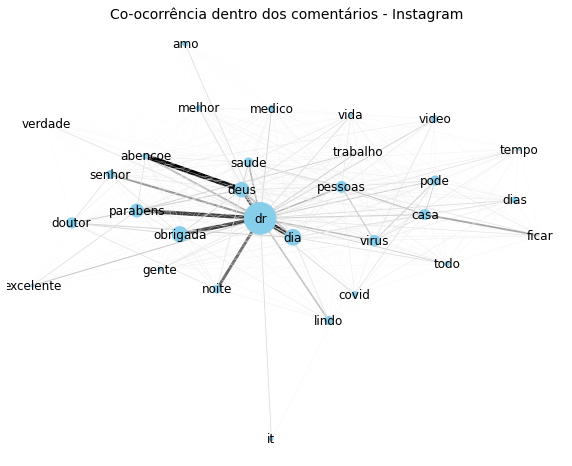

In [10]:
plt.figure(figsize=(10,8))
ax = plt.gca()
ax.set_title('Co-ocorrência dentro dos comentários - Instagram', fontsize=14)

G = nx.Graph()

for i, row in enumerate(co_X):
    for j, co in enumerate(co_X[i]):
        G.add_edge(labels[i], labels[j], weight=(co))

edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
norm_weights = (weights - min(weights)) / (max(weights) - min(weights))
norm_count = (word_count - min(word_count)) / (max(word_count) - min(word_count))

nx.draw(G, with_labels=True, node_color='skyblue', edgelist=edges, width=norm_weights*5,
        edge_color=norm_weights, edge_cmap=cm.get_cmap('binary'), node_size=norm_count*1000,
        pos = nx.spring_layout(G, k=1), ax=ax)
plt.savefig('grafos/geral.png')
plt.show()

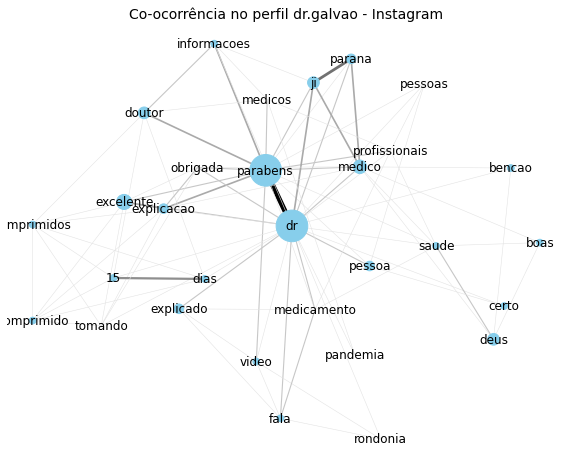

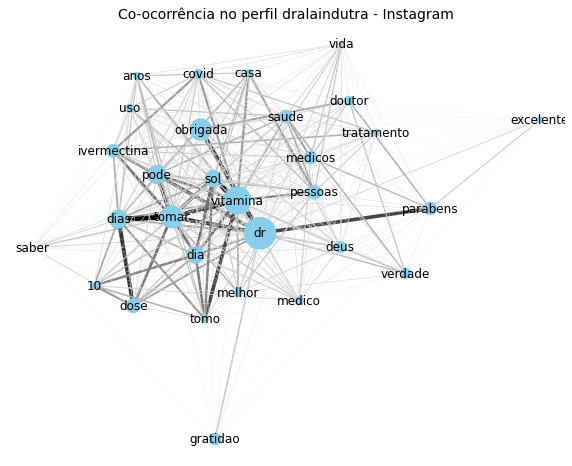

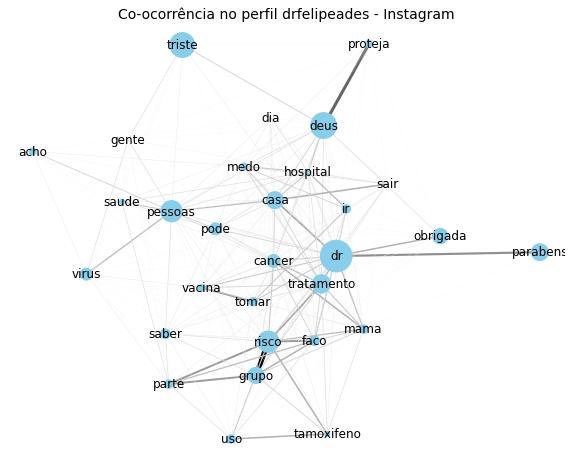

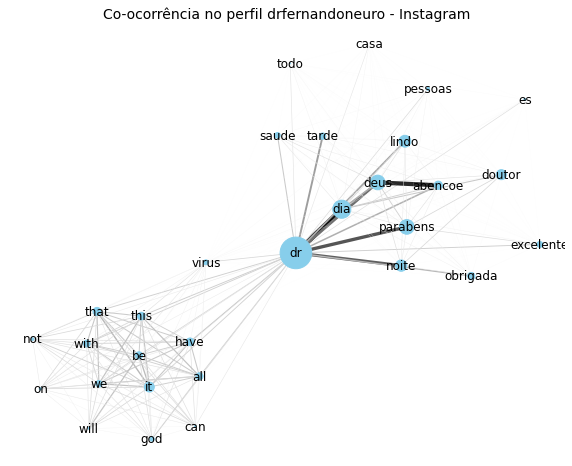

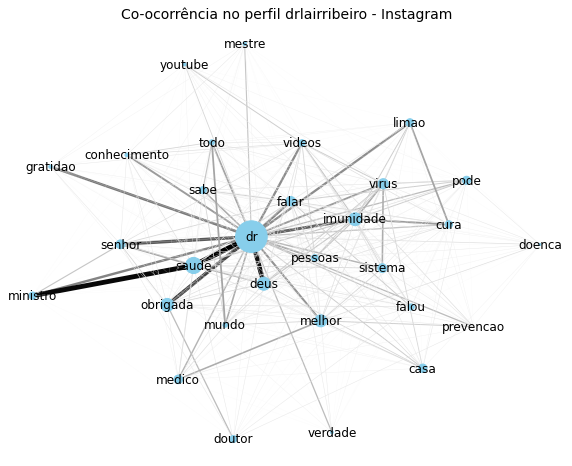

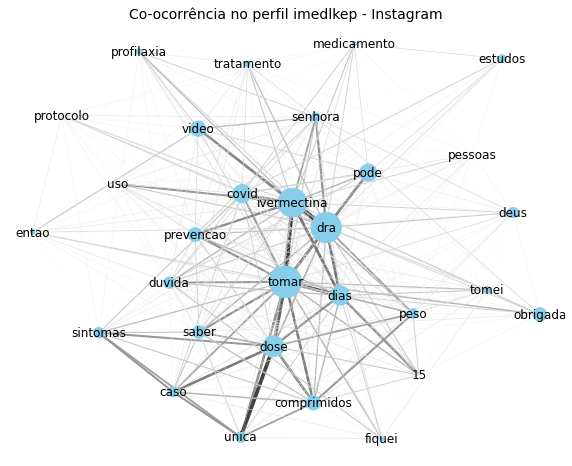

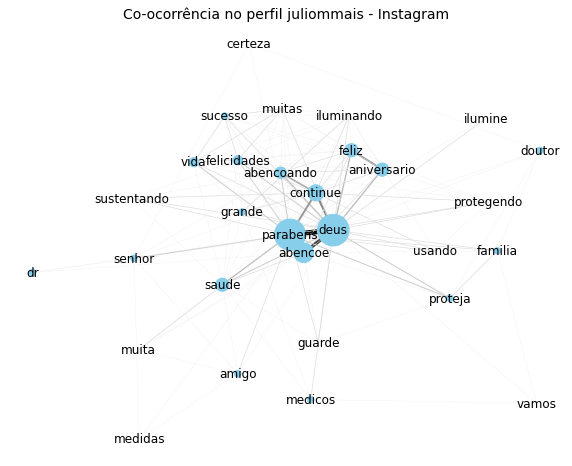

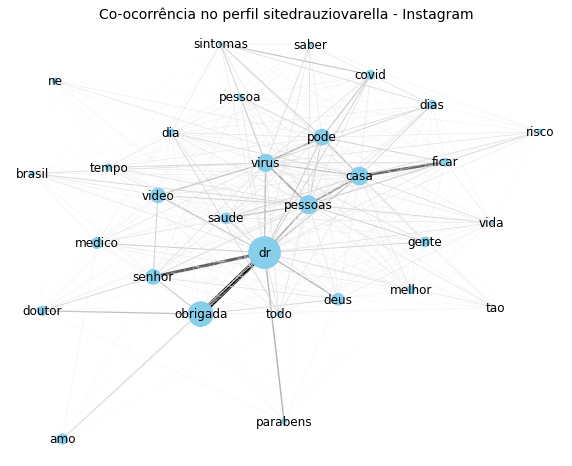

In [11]:
for c, channel in enumerate(comments_by_channel):
    X, labels = word_occurence_matrix(channel)

    word_count = X.sum(axis=0) #no. of comments in which each word appears
    most_freq_zipped = sorted(zip(word_count, labels, X.T), reverse=True)[:N]
    word_count, labels, X_t = zip(*most_freq_zipped)

    X = np.vstack(X_t).T #After unzip, X_t is (words x comments)
    co_X = co_occurence_matrix(X)
    
    plt.figure(figsize=(10,8))
    ax = plt.gca()
    ax.set_title(f'Co-ocorrência no perfil {channels[c]} - Instagram', fontsize=14)

    G = nx.Graph()

    for i, row in enumerate(co_X):
        for j, co in enumerate(co_X[i]):
            G.add_edge(labels[i], labels[j], weight=(co))

    edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
    norm_weights = (weights - min(weights)) / (max(weights) - min(weights))
    norm_count = (word_count - min(word_count)) / (max(word_count) - min(word_count))

    nx.draw(G, with_labels=True, node_color='skyblue', edgelist=edges, width=norm_weights*5,
            edge_color=norm_weights, edge_cmap=cm.get_cmap('binary'), node_size=norm_count*1000,
            pos = nx.spring_layout(G, k=1))
    #plt.savefig(f'grafos/{channels[c]}.png')
    plt.show()

#### 1.1. Co-cocorrência com uma palavra pré-definida

In [38]:
#targets = 'covid', 'peguei', 'tomei', 'fiquei', 'cloroquina', 'ivermectina', 'quarentena'
target = 'quarentena'

X, labels = word_occurence_matrix(comments['texto_do_comentario'] , target=target)

word_count = X.sum(axis=0) #no. of comments containing A in which each word appears
most_freq_zipped = sorted(zip(word_count, labels, X.T), reverse=True)[:N]
word_count, labels, X_t = zip(*most_freq_zipped)

print(f'{N} palavras que mais ocorrem nos mesmos comentários em que "{target}" ocorre:\n')
print(list(zip(labels, word_count))[:N])

X = np.vstack(X_t).T #After unzip, X_t is (words x comments)
co_X = co_occurence_matrix(X)

30 palavras que mais ocorrem nos mesmos comentários em que "quarentena" ocorre:

[('quarentena', 293), ('casa', 66), ('dr', 49), ('pessoas', 44), ('ficar', 33), ('dias', 28), ('virus', 26), ('dia', 24), ('saude', 23), ('sair', 22), ('todo', 21), ('melhor', 21), ('isolamento', 21), ('risco', 20), ('gente', 20), ('tempo', 19), ('pode', 18), ('nessa', 18), ('anos', 18), ('social', 17), ('desde', 17), ('mundo', 16), ('brasil', 16), ('vida', 15), ('quer', 15), ('precisa', 15), ('pandemia', 15), ('momento', 15), ('obrigada', 14), ('deus', 14)]


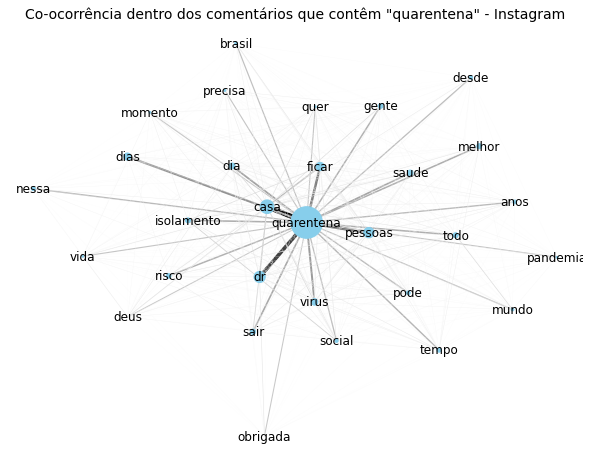

In [39]:
G = nx.Graph()

for i, row in enumerate(co_X):
    for j, co in enumerate(co_X[i]):
        G.add_edge(labels[i], labels[j], weight=(co))

edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
norm_weights = (weights - min(weights)) / (max(weights) - min(weights))
norm_count = (word_count - min(word_count)) / (max(word_count) - min(word_count))

plt.figure(figsize=(8,6))
nx.draw(G, with_labels=True, node_color='skyblue', edgelist=edges, width=norm_weights*5,
        edge_color=norm_weights, edge_cmap=cm.get_cmap('binary'), node_size=norm_count*1000,
        pos = nx.spring_layout(G, k=1))
plt.title(f'Co-ocorrência dentro dos comentários que contêm "{target}" - Instagram', fontsize=14)
plt.savefig(f'grafos/{target}_geral.png')
plt.show()

In [40]:
cc_by_channel = []
cc_channels = []
cc_empty = []
for i, channel in enumerate(comments_by_channel):
    try:
        X, labels = word_occurence_matrix(channel, target=target, stop_words=stop_words)
        word_count = X.sum(axis=0) #no. of comments containing A in which each word appears
        word_count = sorted(zip(labels, word_count), reverse=True, key=lambda tupl : tupl[1])
        cc_by_channel.append(word_count)
        cc_channels.append(channels[i])
    except: #target word doesn't occur in the channel
        cc_empty.append(channels[i])
    

df_cc = pd.DataFrame(cc_by_channel, index = cc_channels).T
print(f'Nenhuma ocorrência de "{target}" nos perfis: ', cc_empty)
print(f'Palavras que mais co-ocorrem nos comentários com "{target}" em cada perfil:')
df_cc.head(10)

Nenhuma ocorrência de "quarentena" nos perfis:  ['drfelipeades', 'imedlkep']
Palavras que mais co-ocorrem nos comentários com "quarentena" em cada perfil:


,dr.galvao,dralaindutra,drfernandoneuro,drlairribeiro,juliommais,sitedrauziovarella
0,"(center, 1)","(quarentena, 10)","(quarentena, 72)","(quarentena, 5)","(colapsar, 1)","(quarentena, 204)"
1,"(clinica, 1)","(casa, 5)","(dr, 22)","(maos, 3)","(coletiva, 1)","(casa, 47)"
2,"(funcionar, 1)","(pessoas, 3)","(casa, 13)","(social, 3)","(disse, 1)","(pessoas, 32)"
3,"(normal, 1)","(saude, 3)","(dia, 12)","(senhor, 2)","(economia, 1)","(ficar, 30)"
4,"(quarentena, 1)","(dinheiro, 2)","(melhor, 8)","(acabar, 1)","(entrevista, 1)","(dr, 26)"
5,None,"(economia, 2)","(pessoas, 8)","(acha, 1)","(estados, 1)","(dias, 23)"
6,None,"(isolamento, 2)","(nessa, 7)","(biblico, 1)","(fechamento, 1)","(virus, 23)"
7,None,"(momento, 2)","(noite, 7)","(casa, 1)","(fronteiras, 1)","(sair, 19)"
8,None,"(social, 2)","(deus, 6)","(causar, 1)","(histeria, 1)","(isolamento, 18)"
9,None,"(trabalhar, 2)","(mascara, 6)","(comprovado, 1)","(medidas, 1)","(todo, 18)"


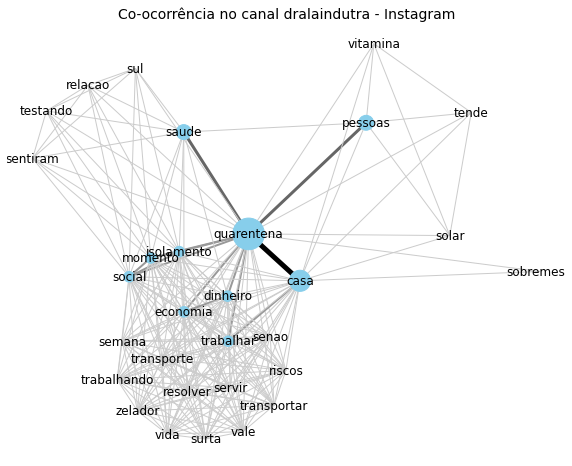

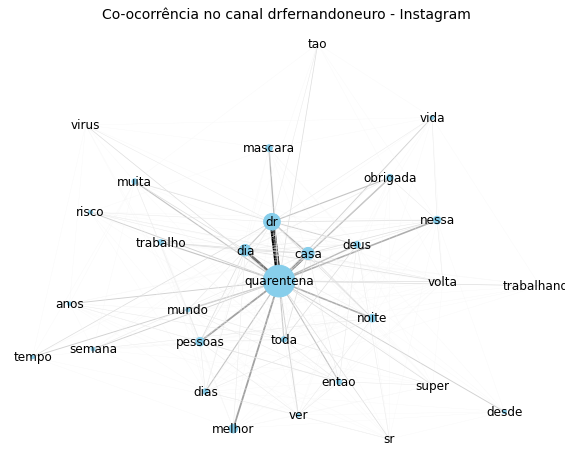

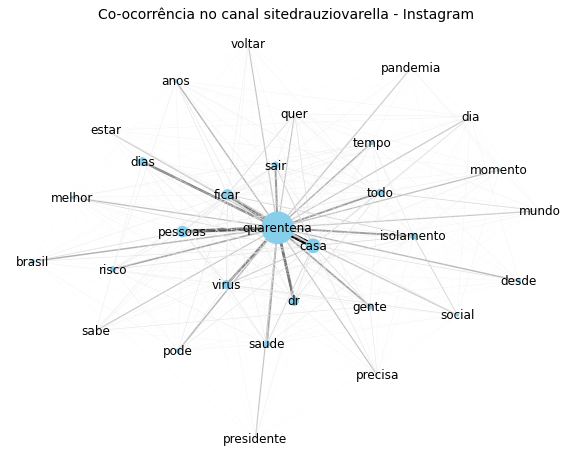

In [41]:
for c, channel in enumerate(comments_by_channel):
    try:
        X, labels = word_occurence_matrix(channel, target=target)

        word_count = X.sum(axis=0) #no. of comments in which each word appears
        most_freq_zipped = sorted(zip(word_count, labels, X.T), reverse=True)[:N]
        word_count, labels, X_t = zip(*most_freq_zipped)
        
        if word_count[0] >= 10:

            X = np.vstack(X_t).T #After unzip, X_t is (words x comments)
            co_X = co_occurence_matrix(X)

            plt.figure(figsize=(10,8))
            ax = plt.gca()
            ax.set_title(f'Co-ocorrência no canal {channels[c]} - Instagram', fontsize=14)

            G = nx.Graph()

            for i, row in enumerate(co_X):
                for j, co in enumerate(co_X[i]):
                    G.add_edge(labels[i], labels[j], weight=(co))

            edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
            norm_weights = (weights - min(weights)) / (max(weights) - min(weights))
            norm_count = (word_count - min(word_count)) / (max(word_count) - min(word_count))

            nx.draw(G, with_labels=True, node_color='skyblue', edgelist=edges, width=norm_weights*5,
                    edge_color=norm_weights, edge_cmap=cm.get_cmap('binary'), node_size=norm_count*1000,
                    pos = nx.spring_layout(G, k=1), ax=ax)
            plt.savefig(f'grafos/{target}_{channels[c]}.png')
            plt.show()
    except:
        pass

#### 1.2. N-gramas

Considerações:

- PMI - favorece n-gramas raros. Muitos n-gramas com a mesma score (a mais alta)

#### PMI

In [94]:
pmi = BigramAssocMeasures().pmi
print(f'{N} com score mais alta:')
score_ngrams(comments['texto_do_comentario'] , score_metric=pmi, freq_filter=10)[:N]

30 com score mais alta:


[(('sok', 'szeretettel'), 14.383766961649712),
 (('gentilmente', 'saudacao'), 14.249674066062429),
 (('tom', 'cruise'), 13.798804460928558),
 (('peaceful', 'quiet'), 13.535770055094764),
 (('batimento', 'cardiaco'), 13.490682165566225),
 (('creusa', 'carvalho'), 13.436234381543848),
 (('einen', 'schonen'), 13.184202469767525),
 (('industria', 'farmaceutica'), 13.153647178288654),
 (('andrea', 'monteiro'), 13.146727764348865),
 (('immune', 'system'), 13.12073255581592),
 (('roberto', 'justus'), 13.103659042456977),
 (('guten', 'morgen'), 13.049347922579154),
 (('efeitos', 'colaterais'), 13.021196882265006),
 (('bleib', 'gesund'), 12.981668518078367),
 (('machado', 'assis'), 12.950807554373606),
 (('memorias', 'postumas'), 12.943194370263733),
 (('dom', 'casmurro'), 12.905719664845067),
 (('vitaminas', 'minerais'), 12.73169026507002),
 (('jak', 'zawsze'), 12.646801367483505),
 (('saudacao', 'manuela'), 12.592561779585438),
 (('pau', 'mandado'), 12.523697222794189),
 (('auto', 'hemoterapi

In [95]:
pmi_by_channel = []
for i, channel in enumerate(comments_by_channel):
    pmi_scores = score_ngrams(channel, score_metric=pmi, freq_filter=10)
    pmi_by_channel.append(pmi_scores)

df_cc = pd.DataFrame(pmi_by_channel, index = channels).T
df_cc.head(10)

,dr.galvao,dralaindutra,drfelipeades,drfernandoneuro,drlairribeiro,imedlkep,juliommais,sitedrauziovarella
0,None,"((industria, farmaceutica), 9.718683962070184)","((grupo, risco), 6.740312989217987)","((sok, szeretettel), 13.278864252231816)","((sistema, imunologico), 6.593702350285316)","((deus, abencoe), 7.152693734705343)","((deus, abencoe), 3.613531652917926)","((home, office), 13.178887115260078)"
1,None,"((tratamento, precoce), 8.221184302599369)","((deus, proteja), 6.1922928144707665)","((gentilmente, saudacao), 13.144771356644537)","((sistema, imune), 6.413130104643496)","((gostaria, saber), 6.814108295864372)","((parabens, deus), 2.613531652917926)","((dom, casmurro), 12.079351441709164)"
2,None,"((000, ui), 8.160255303957037)","((triste, triste), 4.36546372267577)","((tom, cruise), 12.916294172847113)","((ministro, saude), 5.887110405162629)","((dose, unica), 6.268946803201191)",None,"((memorias, postumas), 11.898779196067347)"
3,None,"((covid, 19), 8.027704573178159)",None,"((batimento, cardiaco), 12.764291079402058)",None,"((15, dias), 5.88251725962753)",None,"((machado, assis), 11.745927707983972)"
4,None,"((deus, abencoe), 7.928402553371523)",None,"((peaceful, quiet), 12.430867345676864)",None,"((3, dias), 5.236525325508813)",None,"((seres, humanos), 11.617008227651965)"
5,None,"((gostaria, saber), 7.820646373015638)",None,"((creusa, carvalho), 12.331331672125955)",None,"((pode, tomar), 3.771499690398292)",None,"((taxa, mortalidade), 11.593924614538926)"
6,None,"((gracas, deus), 7.818219635621098)",None,"((redes, sociais), 12.200087138847698)",None,"((tomar, ivermectina), 3.44957159551093)",None,"((pau, mandado), 11.569879140572272)"
7,None,"((todo, mundo), 7.484218708433163)",None,"((andrea, monteiro), 12.179328578680904)",None,None,None,"((atividade, fisica), 11.538783060346464)"
8,None,"((dose, ataque), 7.278111370684202)",None,"((einen, schonen), 12.079299760349633)",None,None,None,"((redes, sociais), 11.472362634658008)"
9,None,"((10, 000), 7.205242758730346)",None,"((immune, system), 12.015829846398024)",None,None,None,"((bla, bla), 11.396278855538162)"


#### likelihood ratio

In [103]:
lr = BigramAssocMeasures().likelihood_ratio
print(f'{N} com score mais alta:')
score_ngrams(comments['texto_do_comentario'] , score_metric=lr, freq_filter=5)[:N]

30 com score mais alta:


[(('deus', 'abencoe'), 6751.794666014501),
 (('covid', '19'), 4437.397090496395),
 (('god', 'bless'), 2868.3488114146908),
 (('grupo', 'risco'), 2663.447642836881),
 (('vitamina', 'd'), 2137.510354139749),
 (('don', 't'), 1937.7321818099633),
 (('conhecer', 'literar'), 1742.475389550113),
 (('deus', 'proteja'), 1710.375224138373),
 (('it', 's'), 1600.6253181776292),
 (('corona', 'virus'), 1547.5243306944926),
 (('ficar', 'casa'), 1546.3841432510708),
 (('vem', 'conhecer'), 1542.0340342350325),
 (('dia', 'dr'), 1521.7780571544467),
 (('falta', 'ar'), 1478.09581634251),
 (('take', 'care'), 1455.6646726709946),
 (('gostaria', 'saber'), 1417.4830543615246),
 (('literar', 'drauziocomliterarse'), 1409.7338565363423),
 (('stay', 'safe'), 1370.1316721110952),
 (('saint', 'petersburg'), 1316.638961580086),
 (('i', 'm'), 1312.2225861238828),
 (('sofiya', 'ivanova'), 1283.2539851494573),
 (('ivanova', 'saint'), 1265.032742334909),
 (('noite', 'dr'), 1237.6519344460314),
 (('nesse', 'momento'), 12

In [104]:
lr_by_channel = []
for i, channel in enumerate(comments_by_channel):
    lr_scores = score_ngrams(channel, score_metric=lr, freq_filter=5)
    lr_by_channel.append(lr_scores)

df_cc = pd.DataFrame(lr_by_channel, index = channels).T
df_cc.head(10)

,dr.galvao,dralaindutra,drfelipeades,drfernandoneuro,drlairribeiro,imedlkep,juliommais,sitedrauziovarella
0,"((ji, parana), 54.54507828915837)","((vitamina, d), 1347.8212492268806)","((grupo, risco), 220.90181433939026)","((deus, abencoe), 4656.253241781253)","((ministro, saude), 227.41777076782142)","((dose, unica), 173.08647497889342)","((deus, abencoe), 60.468436140180465)","((covid, 19), 2255.1245935992815)"
1,"((15, dias), 47.5865044168022)","((vit, d), 223.9788802457357)","((deus, proteja), 110.57497246069045)","((god, bless), 2544.2310352077957)","((sistema, imunologico), 144.4095285610776)","((deus, abencoe), 113.51547741395613)","((feliz, aniversario), 59.063483970399744)","((grupo, risco), 1899.902123426851)"
2,"((parabens, dr), 19.633646318640583)","((deus, abencoe), 220.0689773244118)","((parte, grupo), 74.2042990620457)","((covid, 19), 1900.8826259925304)","((sistema, imune), 132.11871399222505)","((15, dias), 96.6759497574958)","((parabens, deus), 34.47171982969791)","((conhecer, literar), 1603.1600228568918)"
3,None,"((3, dias), 199.97836988043184)","((deus, abencoe), 74.06940342245552)","((don, t), 1746.1461177693582)","((auto, hemoterapia), 100.28235903698877)","((estudos, clinicos), 95.11323743707948)","((deus, continue), 31.174487507599522)","((vem, conhecer), 1478.6153344752556)"
4,None,"((covid, 19), 199.93746242389062)","((uso, tamoxifeno), 62.204948916675555)","((dia, dr), 1456.9208388247807)","((sarah, chaves), 88.3356282394114)","((leda, nagle), 91.58644750006056)",None,"((deus, abencoe), 1331.936294981343)"
5,None,"((000, ui), 180.85899562019083)","((tomar, vacina), 60.7462964838348)","((it, s), 1336.2305316785375)","((deus, abencoe), 87.30939609978365)","((0, 2xpeso), 89.81153821581007)",None,"((falta, ar), 1324.4095421473874)"
6,None,"((industria, farmaceutica), 163.77473226336102)","((vacina, gripe), 57.15389779892141)","((take, care), 1298.6241546244908)","((medicina, chinesa), 78.57203106067863)","((gostaria, saber), 88.5456303591625)",None,"((literar, drauziocomliterarse), 1254.36417142..."
7,None,"((gracas, deus), 157.4869631905315)","((muita, gente), 53.69975954890239)","((saint, petersburg), 1207.8674239293482)","((material, gratuito), 75.43767864033487)","((2xpeso, mg), 87.9314988578441)",None,"((ficar, casa), 1044.3224902679228)"
8,None,"((15, dias), 150.86763242219246)","((cancer, mama), 53.08962277164255)","((stay, safe), 1194.0562022267734)","((bio, vido), 70.0309441339392)","((efeitos, colaterais), 85.45137319683805)",None,"((gostaria, saber), 893.6382425927427)"
9,None,"((gostaria, saber), 149.0099829155059)","((fique, casa), 49.300456470008)","((sofiya, ivanova), 1177.5469654025376)","((clique, linktree), 70.0309441339392)","((sociedades, medicas), 79.73574662356913)",None,"((obrigada, dr), 831.4609491985623)"
